In [10]:
import os
from collections import defaultdict
import pickle

import numpy as np
import matplotlib.pyplot as plt

from utils.parse_logs import parse_metrics

In [11]:
PAR_DIR = './results/drop-edge/short-range'
GNNs = ('GAT', 'GCN')
DATASET = 'Cora'
METRIC = 'F1 Score'

In [12]:
es_test_accs = defaultdict(list)

for exp_dir in os.listdir(PAR_DIR):
    with open(f'{PAR_DIR}/{exp_dir}/config.pkl', 'rb') as f:
        config = pickle.load(f)
    if config.dataset == DATASET and config.gnn in GNNs and config.dropout == 'DropEdge':
        train, val, test = parse_metrics(f'{PAR_DIR}/{exp_dir}/logs')
        if max(train[METRIC]) < 0.2:
            continue
        es_test_acc = test[METRIC][np.argmax(val[METRIC])]
        es_test_accs[(config.gnn, config.drop_p, len(config.gnn_layer_sizes))].append(es_test_acc)

# assert all((len(v) == 5 for v in es_test_accs.values())), list((k for k, v in es_test_accs.items() if len(v) != 5))
es_test_accs = {exp: (np.mean(samples), np.std(samples)) for exp, samples in es_test_accs.items()}

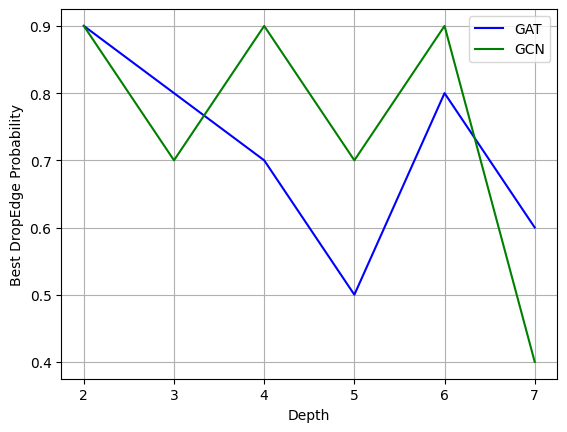

In [13]:
DEPTHS = range(2, 8)
DROP_PS = np.round(np.arange(0.1, 1.0, 0.1), 1)

for gnn, color in zip(GNNs, ('blue', 'green')):
    best_probs = list()
    for depth in DEPTHS:
        best_probs.append(DROP_PS[np.argmax([es_test_accs[(gnn, drop_p, depth)][0] for drop_p in DROP_PS])])
    plt.plot(DEPTHS, best_probs, color=color, label=gnn)

plt.xlabel('Depth')
plt.ylabel('Best DropEdge Probability')
plt.legend()
plt.grid()
plt.show()

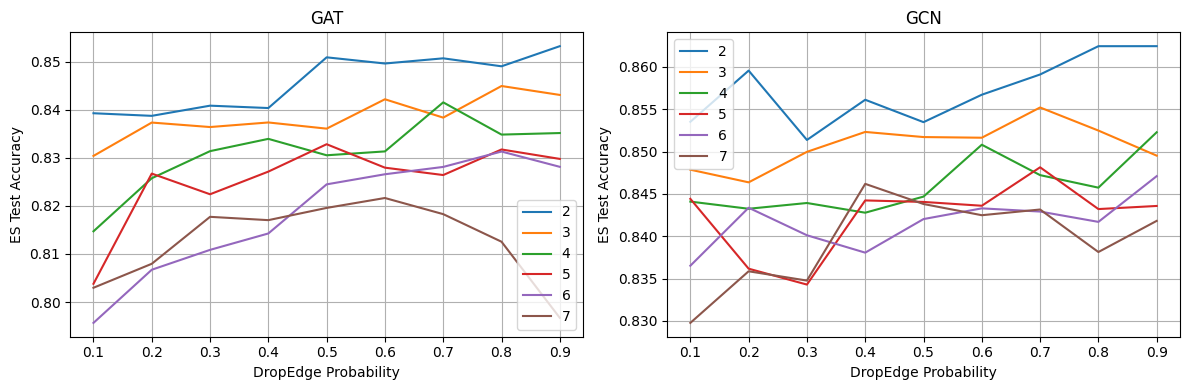

In [14]:
fig, axs = plt.subplots(1, len(GNNs), figsize=(6*len(GNNs), 4))
if not hasattr(axs, '__len__'): axs = (axs,)

for gnn, ax in zip(GNNs, axs):
    for depth in DEPTHS:
        lower = ([es_test_accs[(gnn, drop_p, depth)][0]-es_test_accs[(gnn, drop_p, depth)][1] for drop_p in DROP_PS])
        mean = ([es_test_accs[(gnn, drop_p, depth)][0] for drop_p in DROP_PS])
        upper = ([es_test_accs[(gnn, drop_p, depth)][0]+es_test_accs[(gnn, drop_p, depth)][1] for drop_p in DROP_PS])
        ax.plot(DROP_PS, mean, label=depth)
        # ax.fill_between(DROP_PS, lower, upper, alpha=0.2)
    ax.set_xlabel('DropEdge Probability')
    ax.set_ylabel(f'ES Test {METRIC}')
    ax.set_title(gnn)
    ax.legend()
    ax.grid()

fig.tight_layout()
plt.show()

In [15]:
train_accs = defaultdict(list)

for exp_dir in os.listdir(PAR_DIR):
    with open(f'{PAR_DIR}/{exp_dir}/config.pkl', 'rb') as f:
        config = pickle.load(f)
    if config.dataset == DATASET and config.gnn in GNNs and config.dropout == 'DropEdge':
        train, val, test = parse_metrics(f'{PAR_DIR}/{exp_dir}/logs')
        train_acc = max(train[METRIC])
        if train_acc < 0.2:
            continue
        train_accs[(config.gnn, config.drop_p, len(config.gnn_layer_sizes))].append(train_acc)

# assert all((len(v) == 5 for v in train_accs.values()))
train_accs = {exp: (np.mean(samples), np.std(samples)) for exp, samples in train_accs.items()}

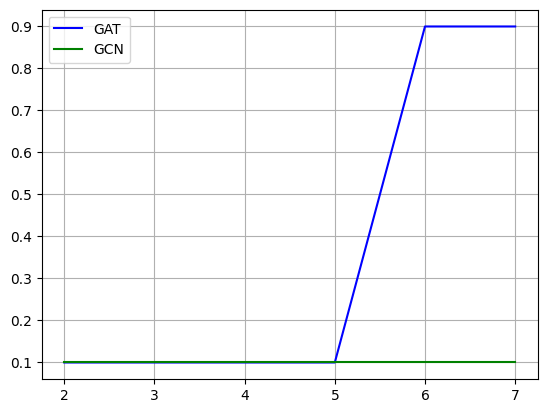

In [16]:
for gnn, color in zip(GNNs, ('blue', 'green')):
    best_probs = list()
    for depth in DEPTHS:
        best_probs.append(DROP_PS[np.argmax([train_accs[(gnn, drop_p, depth)][0] for drop_p in DROP_PS])])
    plt.plot(DEPTHS, best_probs, color=color, label=gnn)

plt.legend()
plt.grid()
plt.show()

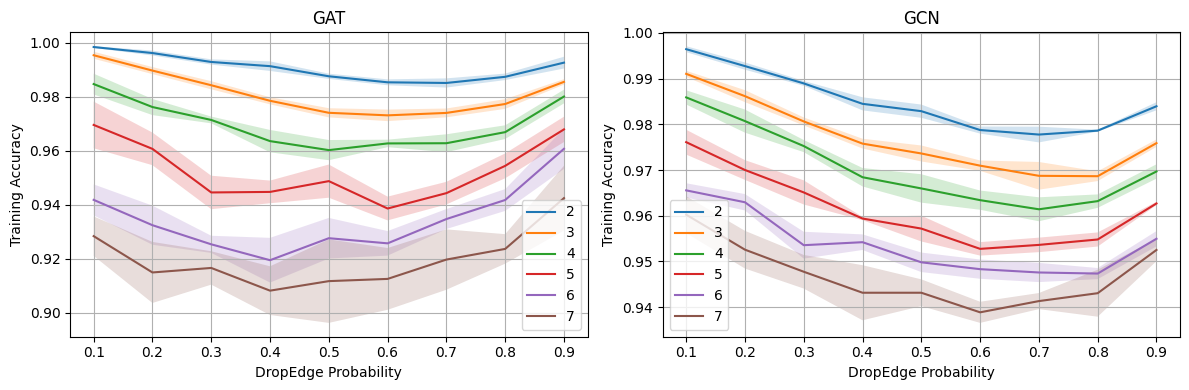

In [17]:
fig, axs = plt.subplots(1, len(GNNs), figsize=(6*len(GNNs), 4))
if not hasattr(axs, '__len__'): axs = (axs,)

for gnn, ax in zip(GNNs, axs):
    for depth in DEPTHS:
        lower = ([train_accs[(gnn, drop_p, depth)][0]-train_accs[(gnn, drop_p, depth)][1] for drop_p in DROP_PS])
        mean = ([train_accs[(gnn, drop_p, depth)][0] for drop_p in DROP_PS])
        upper = ([train_accs[(gnn, drop_p, depth)][0]+train_accs[(gnn, drop_p, depth)][1] for drop_p in DROP_PS])
        ax.plot(DROP_PS, mean, label=depth)
        ax.fill_between(DROP_PS, lower, upper, alpha=0.2)
    ax.set_xlabel('DropEdge Probability')
    ax.set_ylabel(f'Training {METRIC}')
    ax.set_title(gnn)
    # ax.set_ylim((0.92, 1.0))
    ax.legend()
    ax.grid()

fig.tight_layout()
plt.show()

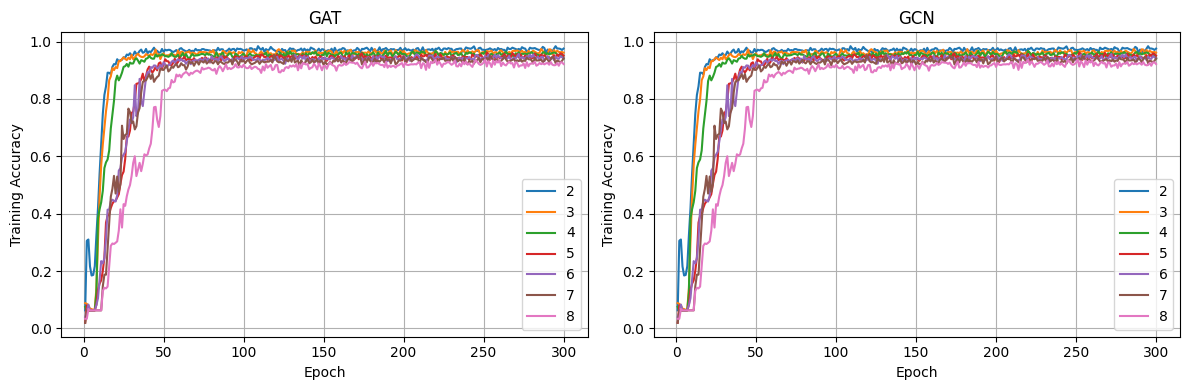

In [18]:
fig, axs = plt.subplots(1, len(GNNs), figsize=(6*len(GNNs), 4))
if not hasattr(axs, '__len__'): axs = (axs,)

for gnn, ax in zip(GNNs, axs):
    plotted = set()
    for exp_dir in os.listdir(PAR_DIR):
        with open(f'{PAR_DIR}/{exp_dir}/config.pkl', 'rb') as f:
            config = pickle.load(f)
        depth = len(config.gnn_layer_sizes)
        if config.dataset == DATASET and config.gnn in GNNs and config.dropout == 'DropEdge' and config.drop_p == 0.9 and depth not in plotted:
            train, val, test = parse_metrics(f'{PAR_DIR}/{exp_dir}/logs')
            ax.plot(train['Epoch'], train[METRIC], label=depth)
            plotted.add(depth)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(f'Training {METRIC}')
    ax.set_title(gnn)
    ax.grid()
    ax.legend()

fig.tight_layout()
plt.show()